In [1]:
from spear.flows import Expense, TaxableIncome
from spear.assets import Asset, TaxableAsset, PretaxAsset
from spear.growth import GrowthType
from spear.events import Event, Action
from spear.model import FinancialModel

Revenues have a fixed value, and expenses grow with a fixed inflation rate.
The state is used to calculate taxes.

In [26]:
salary = TaxableIncome(name="Salary", initial_value=70_000, state="MA")
housing = Expense(name="Housing", initial_value=20_000, inflation_rate=0.02)
cost_of_living = Expense(name="Cost of Living", initial_value=20_000, inflation_rate=0.03)

Assets can be specified with a fixed growth rate, and a cap on the total value, after which surplus money goes into assets without a cap; you can also specify a `cap_deposit` to limit how much money goes into a particular asset each year.

Assets with growth type will grow with a rate sampled from historical data; the allocations must collectively equal 1, and weigh deposits into each asset.


In [27]:
cash = Asset(name="Cash", initial_value=5_000, growth_rate=0.01, cap_value=10_000)

bonds = TaxableAsset(
    name="Bonds",
    initial_value=10_000,
    allocation=0.1,
    growth_type=GrowthType.BONDS,
    seed=42
)
stocks = TaxableAsset(
    name="Stocks",
    initial_value=20_000,
    allocation=0.9,
    growth_type=GrowthType.STOCKS,
    seed=42
)
_401k = PretaxAsset(
    name="401k",
    initial_value=10_000,
    growth_type=GrowthType.STOCKS,
    age=30,
    state="MA",
    seed=42
)

Events include actions on methods of any of your financial objects; say you want to quit your job, after which your salary goes to 0, and you now have to pay for health insurance.

In [28]:
health_insurance = Expense(name="Health Insurance", initial_value=0, inflation_rate=0.03)
quit_job = Event(
    name="Quit Job",
    year=2040,
    actions=[
        Action(
            target=salary,
            action="update_base_values",
            params={"new_base_values": 0, "duration": 100},
        ),
        Action(
            target=health_insurance,
            action="update_base_values",
            params={"new_base_values": 2_000, "duration": 100},
        ),
    ],
)


In each year, the order of operations is:

1. Balance cash flow.
   - Negative cash flow acumulates as debt.
   - Positive cash flow is distributed among assets.
2. Invest in pre-tax assets.
3. Tax revenues.
4. Distribute cash flow among assets.
5. Grow assets.
6. Add inflation to expenses.


In [29]:
model = FinancialModel(
    revenues=[salary],
    expenses=[housing, cost_of_living, health_insurance],
    assets=[cash, bonds, stocks, _401k],
    events=[quit_job],
    duration=30, # years
    number_of_simulations=1_000,
    age=30,
)
model.run()


And plot the median results with 95% confidence intervals over all simulations:

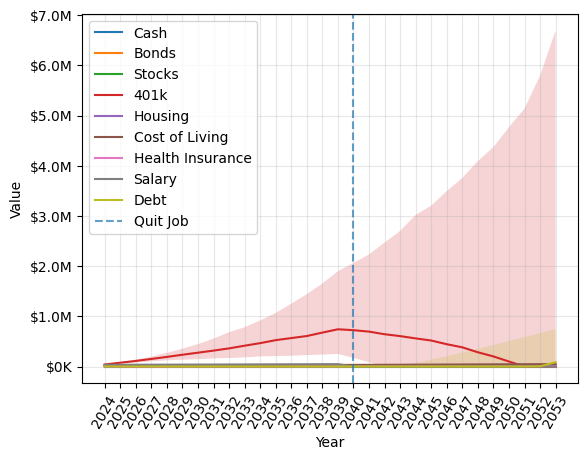

In [34]:
ax = model.plot_all();

Currently, financial objects are modified in-place during simulations, so you should create new instances for different simulations; you can also plot each of them individually:

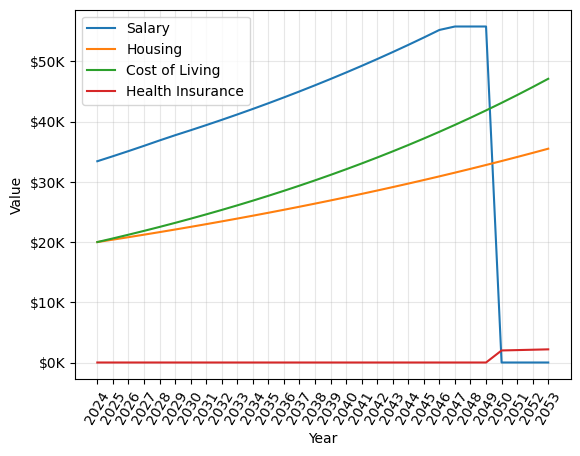

In [25]:
[flow.plot(duration=30) for flow in [salary, housing, cost_of_living, health_insurance]];